In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
pd.set_option('display.max_columns', None)

In [46]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/obulygin/pyda_homeworks/master/statistics_basics/horse_data.csv',
    header=None
)

In [47]:
df.columns = [
    'surgery', 'age', 'hospital_id', 'rectal_temperature',
    'pulse', 'respiratory_rate', 'exc_temperature',
    'peripheral_pulse', 'mucous_membranes', 'capillary refill time',
    'pain', 'peristalsis', 'abdominal_distension', 'nasogastric_tube',
    'nasogastric_reflux', 'nasogastric_reflux_PH', 'rectal_examination_feces',
    'abdomen', 'packed_cell_volume', 'total_protein',
    'abdominocentesis_appearance', 'abdomcentesis_total_protein',
    'outcome', 'surgical_lesion', 'first_lesion', 'second_lestion',
    'third_lesion', 'cp_data'
]

### 1. Surgery
          1 = Yes, it had surgery
          2 = It was treated without surgery

In [6]:
df['surgery'].value_counts()

1    180
2    119
?      1
Name: surgery, dtype: int64

Пропущено всего одно значение, посмотрим внимательнее на строку с пропущенным значением.

In [7]:
df[df['surgery'] == '?']

,surgery,age,hospital_id,rectal_temperature,pulse,respiratory_rate,exc_temperature,peripheral_pulse,mucous_membranes,capillary refill time,pain,peristalsis,abdominal_distension,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_PH,rectal_examination_feces,abdomen,packed_cell_volume,total_protein,abdominocentesis_appearance,abdomcentesis_total_protein,outcome,surgical_lesion,first_lesion,second_lestion,third_lesion,cp_data
132,?,1,534572,38.0,48,20,3,1,3,1,4,3,1,2,1,?,3,5,43,73,2,1,?,1,3111,0,0,2


В данной строке есть информация о хирургическом вмешательстве, но отсутствуют данные об исходе операции. Это странно.

In [8]:
df['outcome'].value_counts()

1    178
2     77
3     44
?      1
Name: outcome, dtype: int64

Более того, это единственная строка с неясным исходом для лошади. Может она убежала во время операции? Такую строку лучше удалить.

In [9]:
df = df[df['surgery'] != '?']

Базовая статистика по столбцу:

In [10]:
print(df['surgery'].value_counts(normalize=True))
len(df)

1    0.602007
2    0.397993
Name: surgery, dtype: float64


299

### 2. Age
          1 = Adult horse
          2 = Young (< 6 months)


In [11]:
df['age'].value_counts()

1    275
9     24
Name: age, dtype: int64

В столбце возраст встречается значение 9, которое не указано в описании столбца. Возможно, это ошибка обозначения возраста молодых лошадей, но также 9 может обозначать утерянные значения.

Строки со значением возраста 9 не стоит исключать из дальнейшего анализа. Однако не стоит исползовать данные из этого столбца как порядковые и делать на их основе выводы о молодых лошадях.

### 3. Hospital Number
          - numeric id
          - the case number assigned to the horse
            (may not be unique if the horse is treated > 1 time)

In [18]:
df['hospital_id'].describe()

count    2.990000e+02
mean     1.087733e+06
std      1.532032e+06
min      5.184760e+05
25%      5.289040e+05
50%      5.303010e+05
75%      5.347360e+05
max      5.305629e+06
Name: hospital_id, dtype: float64

In [12]:
print(df.loc[df['hospital_id'] < 100, 'hospital_id'])

Series([], Name: hospital_id, dtype: int64)


В колонке госпитального номера нет пропоусков.

In [13]:
print(np.unique(df['hospital_id'].value_counts().values, return_counts=True))

(array([1, 2]), array([267,  16]))


267 лошадей были в госпитале один раз, 16 -- дважды. Т.е. в датасете есть инормация о 275 лошадях.

In [14]:
8/275*100

2.909090909090909

3% всех лошадей были в госпитале дважды. При необходимости использования методов, требующих статистическую независимость данных, необходимо исключить данные о повторных госпитолизациях. 

### 4. rectal temperature
          - linear
          - in degrees celsius.
          - An elevated temp may occur due to infection.
          - temperature may be reduced when the animal is in late shock
          - normal temp is 37.8
          - this parameter will usually change as the problem progresses
               eg. may start out normal, then become elevated because of
                   the lesion, passing back through the normal range as the
                   horse goes into shock

In [15]:
df['rectal_temperature'] = (df['rectal_temperature'].
    apply(pd.to_numeric, errors='coerce'))

Поиск выбросов

In [16]:
q1 = df['rectal_temperature'].quantile(0.25)
q3 = df['rectal_temperature'].quantile(0.75)
iqr = q3 - q1
lower_outlier = q1 - iqr
higher_outlier = q3 + iqr

print(f"Lower outlier margin: {lower_outlier:.1f}")
print("lowest temperature in dataset:", df['rectal_temperature'].min())
print('Number of lower outliers: ', sum(df['rectal_temperature'] < lower_outlier), '\n')

print(f"Higher outlier margin: {higher_outlier:.1f}")
print("highest temperature in dataset:", df['rectal_temperature'].max())
print('Number of higher outliers:', sum(df['rectal_temperature'] > higher_outlier))

Lower outlier margin: 37.1
lowest temperature in dataset: 35.4
Number of lower outliers:  11 

Higher outlier margin: 39.2
highest temperature in dataset: 40.8
Number of higher outliers: 18


Самая низкая температура из датасета выше нижней физиологической нормы для лошадей. Самая высокая тоже совместима с жизнью. Большое количество выбросов надйенное при рассчётах говорит о том, что в датасете много данных о лошадях с нормальной температурой тела.
https://horsefacts.net/horses-body-temperature/

In [17]:
print(df['rectal_temperature'].describe(), '\n')
all_rt = len(df)
missed_rt = df['rectal_temperature'].isnull().sum()
print('Missed values ', missed_rt)

print('Percent of missed values ', round(missed_rt/all_rt*100, 1), '%')

count    239.000000
mean      38.168619
std        0.733744
min       35.400000
25%       37.800000
50%       38.200000
75%       38.500000
max       40.800000
Name: rectal_temperature, dtype: float64 

Missed values  60
Percent of missed values  20.1 %


In [ ]:
plt.hist(df['rectal_temperature'])

20% данных о ректальной температуре утеряно. Это слишком высокий процент, чтобы мы могли откинуть строки с пропусками. Пропущенные значения можно попробовать заменить средним арифметических существующих значений, которое близко к физиологической норме для лошадей. Для улучшения импутации можно попробовать усреднять данные внутри возрастных групп, поскольку известно, что у жеребят температура тела несколько выше, чем у взрослых лошадей.

In [ ]:
(df['rectal_temperature'].
    fillna(df.groupby(['age'])['rectal_temperature'].
    transform('mean'), inplace=True)
)
df['rectal_temperature'].describe()

### 5. pulse
          - linear
          - the heart rate in beats per minute
          - is a reflection of the heart condition: 30 -40 is normal for adults
          - rare to have a lower than normal rate although athletic horses
            may have a rate of 20-25
          - animals with painful lesions or suffering from circulatory shock
            may have an elevated heart rate

In [ ]:
df['pulse'] = df['pulse'].apply(pd.to_numeric, errors='coerce')
plt.hist(df['pulse'])

In [ ]:
q1 = df['pulse'].quantile(0.25)
q3 = df['pulse'].quantile(0.75)
iqr = q3 - q1
lower_outlier = q1 - iqr
higher_outlier = q3 + iqr

print(f"Lower outlier margin: {lower_outlier:.1f}")
print("lowest pulse in dataset:", df['pulse'].min())
print('Number of lower outliers: ', sum(df['pulse'] < lower_outlier), '\n')

print(f"Higher outlier margin: {higher_outlier:.1f}")
print("highest pulse in dataset:", df['pulse'].max())
print('Number of higher outliers:', sum(df['pulse'] > higher_outlier))

Наш метод обнаружения выборосов не нашёл ничего подозрительного на нижней границе распределения.
Зато на верхней границе обнаружилось 13 выбросов. Судя по данным из интернета, сердцебиение в 184 ударов в минуту у лошадей бывает.

Гистограмма распределения имеет сильно ассиметричный вид с пиком в районе пульса здоровых особей и с длинным хвостом справа. Применённый метод поиска выбросов ориентирован на более симметричные распределения, поскольку для верхней и нижней граней имеет одинаковую форму. Нет оснований исключать из рассмотрения найденные "выбросы".

In [ ]:
df['pulse']
df['pulse'].isnull().sum()

In [ ]:
(df['pulse'].
    fillna(df.groupby(['age'])['pulse'].
    transform('median'), inplace=True)
)
df['pulse'].describe()

### 6. respiratory rate
          - linear
          - normal rate is 8 to 10
          - usefulness is doubtful due to the great fluctuations

In [20]:
df['respiratory_rate'].describe()

count     299
unique     41
top         ?
freq       58
Name: respiratory_rate, dtype: object

/home/xbbt/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/xbbt/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([53., 68., 45., 39., 13.,  6.,  4.,  3.,  5.,  5.]),
 array([ 8. , 16.8, 25.6, 34.4, 43.2, 52. , 60.8, 69.6, 78.4, 87.2, 96. ]),
 <BarContainer object of 10 artists>)

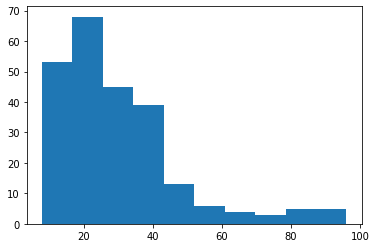

In [21]:
df['respiratory_rate'] = (df['respiratory_rate'].
    apply(pd.to_numeric, errors='coerce'))
plt.hist(df['respiratory_rate'])

In [22]:
q1 = df['respiratory_rate'].quantile(0.25)
q3 = df['respiratory_rate'].quantile(0.75)
iqr = q3 - q1
lower_outlier = q1 - iqr
higher_outlier = q3 + iqr

print(f"Lower outlier margin: {lower_outlier:.1f}")
print("lowest respiratory rate in dataset:", df['respiratory_rate'].min())
print('Number of lower outliers: ', sum(df['respiratory_rate'] < lower_outlier), '\n')

print(f"Higher outlier margin: {higher_outlier:.1f}")
print("highest respiratory rate in dataset:", df['respiratory_rate'].max())
print('Number of higher outliers:', sum(df['respiratory_rate'] > higher_outlier))

Lower outlier margin: 0.0
lowest respiratory rate in dataset: 8.0
Number of lower outliers:  0 

Higher outlier margin: 54.0
highest respiratory rate in dataset: 96.0
Number of higher outliers: 22


22 выброса нашла наша процедура. На гистограмме распределение частоты дыхания большинство из них находится в районе правого пика. Возможно, они действительно выбросы. Возможно, ветеринары чаще измеряют частоту дыхания, если она очевидным образом велика. На всякий случай исключим все значения выше 54.

In [23]:
df['respiratory_rate'][df['respiratory_rate'] > 54] = np.nan
df['respiratory_rate'].max()

<ipython-input-23-bce0a61f4c77>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['respiratory_rate'][df['respiratory_rate'] > 54] = np.nan


52.0

In [24]:
df['respiratory_rate'].isnull().sum()

80

В рассматриваемом столбце оказывается 80 пропущенных значений, что очень много. Из-за высокой вариабельности в частотсе дыхания ветеринары могут измерять частоту дыхания только при отдельных патологиях. В данной ситуации, на мой взгляд, лучше не замещать пропущенные значения, а использовать one-hot enconding.

### 7. peripheral pulse
          - subjective
          - possible values are:
               1 = normal
               2 = increased
               3 = reduced
               4 = absent
          - normal or increased p.p. are indicative of adequate circulation
            while reduced or absent indicate poor perfusion

In [ ]:
df['peripheral_pulse'].describe()

count    230.000000
mean       2.021739
std        1.042527
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: peripheral_pulse, dtype: float64


(array([114.,   0.,   0.,   5.,   0.,   0., 103.,   0.,   0.,   8.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

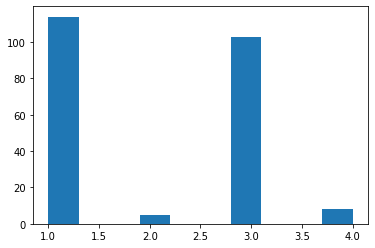

In [28]:
df['peripheral_pulse'] = (df['peripheral_pulse'].
    apply(pd.to_numeric, errors='coerce'))
plt.hist(df['peripheral_pulse'])

In [33]:
df['peripheral_pulse'].describe()

count    230.000000
mean       2.021739
std        1.042527
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: peripheral_pulse, dtype: float64

In [30]:
print(df['peripheral_pulse'].isnull().sum())

69


Выбросов в столбце нет. Пропущенных значений довольно много, их нельзя откинуть без вреда для анализа данных. Возможно, в записи не попали данные о переферическом пульсе, когда он был неважен. Пропуски можно заменить значением моды т. е. 1 (нормальный пульс).  Дополнительно может быть полезен one-hot encoding.

In [36]:
df['peripheral_pulse'].value_counts(normalize=True)

1.0    0.495652
3.0    0.447826
4.0    0.034783
2.0    0.021739
Name: peripheral_pulse, dtype: float64

### 8. mucous membranes
          - a subjective measurement of colour
          - possible values are:
               1 = normal pink
               2 = bright pink
               3 = pale pink
               4 = pale cyanotic
               5 = bright red / injected
               6 = dark cyanotic
          - 1 and 2 probably indicate a normal or slightly increased
            circulation
          - 3 may occur in early shock
          - 4 and 6 are indicative of serious circulatory compromise
          - 5 is more indicative of a septicemia

In [53]:
df['mucous_membranes'].unique()

array(['?', '4', '3', '6', '1', '5', '2'], dtype=object)

/home/xbbt/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/xbbt/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([79.,  0., 30.,  0., 58.,  0., 41.,  0., 25., 20.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

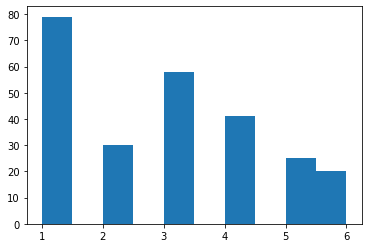

In [54]:
df['mucous_membranes'] = (df['mucous_membranes'].
    apply(pd.to_numeric, errors='coerce'))
plt.hist(df['mucous_membranes'])

In [55]:
df['mucous_membranes'].isnull().sum()

47

В данном столбце довольно много пропущенных значений, исключить их всех из анализа было бы опрометчиво. Поскольку цвет слизистой упорядоченный нечисловой признак, замена средним невозможна. В данном случае можно сделать замену модой, сделав вариантом по умолчанию значений "нормально розовый".

In [56]:
df['mucous_membranes'].describe()

count    253.000000
mean       2.853755
std        1.620294
min        1.000000
25%        1.000000
50%        3.000000
75%        4.000000
max        6.000000
Name: mucous_membranes, dtype: float64

In [58]:
df['mucous_membranes'].value_counts(normalize=True)

1.0    0.312253
3.0    0.229249
4.0    0.162055
2.0    0.118577
5.0    0.098814
6.0    0.079051
Name: mucous_membranes, dtype: float64